In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory

# For example, running this (by clickingrun or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidewatch/SuicideWatch.csv
/kaggle/input/suicidal-mental-health-dataset/mental-health.csv
/kaggle/input/suicide-watch/Suicide_Detection.csv


In [86]:
import tensorflow as tf
import keras
from keras import layers, optimizers

from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

import keras_tuner as kt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [63]:
df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')
df = df.loc[:, 'text':]
df['class'] = df['class'].str.lower()

binarized = []
for label in df['class']:
    if label == 'suicide':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='class')
df = df.drop('class', axis=1)
df = pd.concat([df, binarized], axis=1)
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...
232069,If you don't like rock then your not going to ...,0
232070,You how you can tell i have so many friends an...,0
232071,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,The usual stuff you find hereI'm not posting t...,1


In [64]:
train_df, other = train_test_split(
    df,
    test_size = 0.1,
    random_state = 9730,
    shuffle = True,
    stratify = df['class'],
)

val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9730,
    shuffle = True,
    stratify = other['class'],
)

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['class'].values)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['class'].values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['class'].values)
)

In [66]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [67]:
BATCH_SIZE = 16
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

In [68]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [69]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'my friend thinks it\'s weird that i say amn\'t like i don\'t say "aren\'t i" i said "amn\'t i."\nanother example instead of "i\'m not able" i\'d say "i amn\'t able."\nanyone have any strong thoughts about that?'
0

b'the cold sore did me inlet me prefix this with saying that cold sores are not that bad, but it was enough to push me over the edge. \n\nso, i\'ve only for sure had one, and i may have had one or two more about a month or two later--but they didn\'t have apparent symptoms. the point being is that i haven\'t had anything since my first initial outbreak two years ago. combine this fact along with the fact that i thought 80% of the population already had it, and that it was very rare to give it when you do not have symptoms. i was wrong. only 60% of the us population has it (40% is far to high for me to just not care), and you can fairly regularly give it when you have no symptoms. so, now, if i ever want to kiss a girl again, i have to warn her that i\'ve had cold sores, an

In [70]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

426470


In [71]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [72]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [43]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [73]:
print(f'Tokens: {vocab[24:101]}')

Tokens: ['7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '¡', '£', '§', '¨', '©', 'ª', '«', '¯', '°', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Æ', 'Ì', 'Î', 'Ï', 'Ñ', 'Ó', 'Ö']


In [74]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [75]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'my friend thinks it\'s weird that i say amn\'t like i don\'t say "aren\'t i" i said "amn\'t i."\nanother example instead of "i\'m not able" i\'d say "i amn\'t able."\nanyone have any strong thoughts about that?', shape=(), dtype=string)
Tokens:  tf.Tensor(
[ 986 1130 1738  987    8   56 1430  990   46 1114 1028 2062    8   57
 1004   46 1003    8   57 1114    3 1584    8   57   46    3   46 1148
    3 1028 2062    8   57   46   15    3 1228 2343 1447  988    3   46
    8   50 1007 1242    3   46    8   41 1114    3   46 1028 2062    8
   57 1242   15    3 1100  995 1068 1638 1195 1012  990   30    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0

In [76]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()

In [77]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [78]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [96]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model



def create_model(vocabulary_size):
    input_ids = Input(shape=(512,), dtype="int64", name="input_ids")
    
    # Embedding layer with masking
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=512,
        embedding_dim=128,
        mask_zero=False,
    )(input_ids)

   
    # Bidirectional LSTM with explicit mask
    x = layers.Bidirectional(
        layers.LSTM(
            32,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.001),
            use_cudnn=False
        )
    )(x)

    # Dense layer for binary classification
    outputs = Dense(1, activation="sigmoid")(x)

    # Compile the model
    model = Model(input_ids, outputs, name="BiEscalator")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [80]:
mask = model.layers[1].compute_mask(input_data)
print(mask)

NameError: name 'model' is not defined

## Hyperparameter Tuning

In [126]:
import keras_tuner as kt
tuner = kt.BayesianOptimization(
    hypermodel = BiEscalator,
    objective = 'val_loss',
    overwrite = True,
    max_trials = 10
)
tuner.search(train_dataset, validation_data = val_dataset, epochs = 10, verbose = 1)

ValueError: Inputs to a layer should be tensors. Got '<keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7cc843191d80>' (of type <class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>) as input for layer 'BiEscalator'.

# Modelling RAHHHHH


In [97]:
BiEscalator = create_model(426470)
BiEscalator.summary()

Model: "BiEscalator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_6       │ (None, 512, 128)            │      54,653,696 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,694,977 (208.64 MB)

 Trainable params: 54,694,977 (208.64 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Get one batch from the dataset
for inputs, targets in train_dataset.take(1):
    input_ids = inputs["input_ids"]
    break
embedding_layer = BiEscalator.layers[1]
mask = embedding_layer.compute_mask(input_ids)
print("Computed mask:", mask)

Computed mask: None


In [99]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)

In [100]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = "auto",
    restore_best_weights = True,
)

In [101]:
history = BiEscalator.fit(
    train_dataset,
    epochs=50, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 716s 54ms/step - accuracy: 0.9024 - loss: 0.2815 - val_accuracy: 0.9475 - val_loss: 0.1482 - learning_rate: 3.0000e-04
Epoch 2/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 702s 54ms/step - accuracy: 0.9565 - loss: 0.1272 - val_accuracy: 0.9535 - val_loss: 0.1331 - learning_rate: 3.0000e-04
Epoch 3/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 701s 54ms/step - accuracy: 0.9647 - loss: 0.1035 - val_accuracy: 0.9589 - val_loss: 0.1193 - learning_rate: 3.0000e-04
Epoch 4/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 701s 54ms/step - accuracy: 0.9701 - loss: 0.0894 - val_accuracy: 0.9596 - val_loss: 0.1190 - learning_rate: 3.0000e-04
Epoch 5/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 701s 54ms/step - accuracy: 0.9751 - loss: 0.0770 - val_accuracy: 0.9583 - val_loss: 0.1233 - learning_rate: 3.0000e-04
Epoch 6/50
13055/13055 ━━━━━━━━━━━━━━━━━━━━ 702s 54ms/step - accuracy: 0.9785 - loss: 0.0680 - val_accuracy: 0.9569 - val_loss: 0.1339 - learning_rate: 3.0000e-04
Epoch 7/50
13055/13055

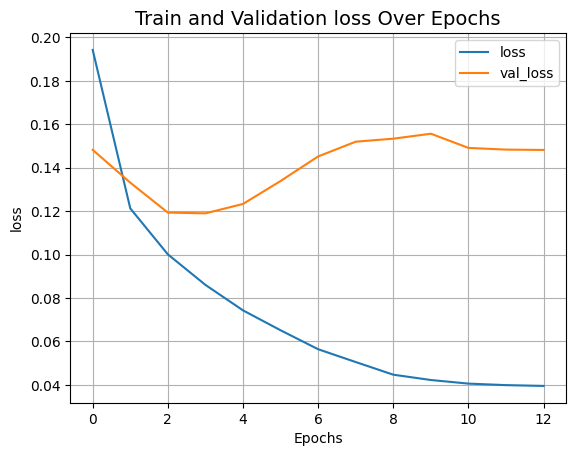

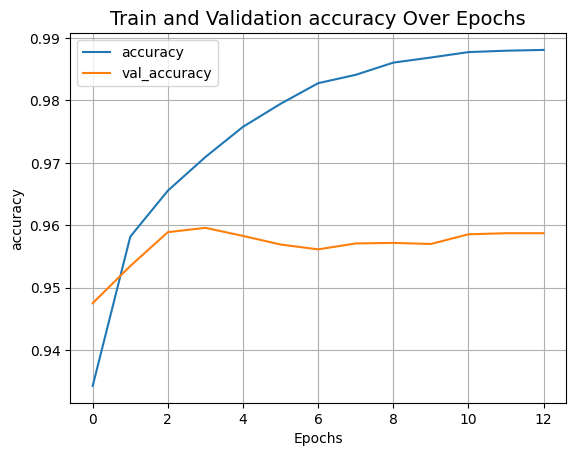

In [102]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [103]:
BiEscalator.evaluate(test_dataset)

726/726 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9587 - loss: 0.1130


[0.11064472794532776, 0.9607893824577332]